In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime, timedelta

In [2]:
db_path = "../data/processed/cmesrcV3.db"

conn = sqlite3.connect(db_path)
cur = conn.cursor()

In [3]:
# Load all CMEs

cmes = pd.read_sql("SELECT * FROM CMES WHERE cme_date > (SELECT MIN(timestamp) FROM processed_harps_bbox) AND cme_date < (SELECT MAX(timestamp) FROM processed_harps_bbox)", conn)
cmes["cme_date"] = pd.to_datetime(cmes["cme_date"])
cmes['cme_date_numeric'] = cmes['cme_date'].apply(lambda x: mdates.date2num(x))
print(len(cmes))
cmes.head()

14507


,cme_id,cme_date,cme_pa,cme_width,cme_halo,cme_seen_in,cme_three_points,cme_quality,image_timestamp,cme_date_numeric
0,20100501004805101,2010-05-01 00:48:05,101.0,126.0,0,0,0,0,2010-05-01 00:48:00,14730.033391
1,20100501053607292,2010-05-01 05:36:07,292.0,21.0,0,1,0,2,2010-05-01 05:36:00,14730.233414
2,20100501071205111,2010-05-01 07:12:05,111.0,108.0,0,0,0,0,2010-05-01 07:12:00,14730.300058
3,20100501131206084,2010-05-01 13:12:06,84.0,69.0,0,0,0,1,2010-05-01 13:12:00,14730.550069
4,20100501202406215,2010-05-01 20:24:06,215.0,8.0,0,1,0,2,2010-05-01 20:24:00,14730.850069


In [4]:
date_pa = cmes[["cme_date_numeric", "cme_pa", "cme_date", "cme_width"]].dropna().to_numpy()

# dates = np.array([np.datetime64(date) for date in date_pa[:, 0]], dtype=np.datetime64)
dates = date_pa[:, 0].astype(np.float64)
pas = date_pa[:, 1].astype(np.float64)
or_dates = date_pa[:, 2]
widths = date_pa[:, 3].astype(np.float64)

type(dates[0])
dates[:5]

array([14730.0333912 , 14730.23341435, 14730.30005787, 14730.55006944,
       14730.85006944])

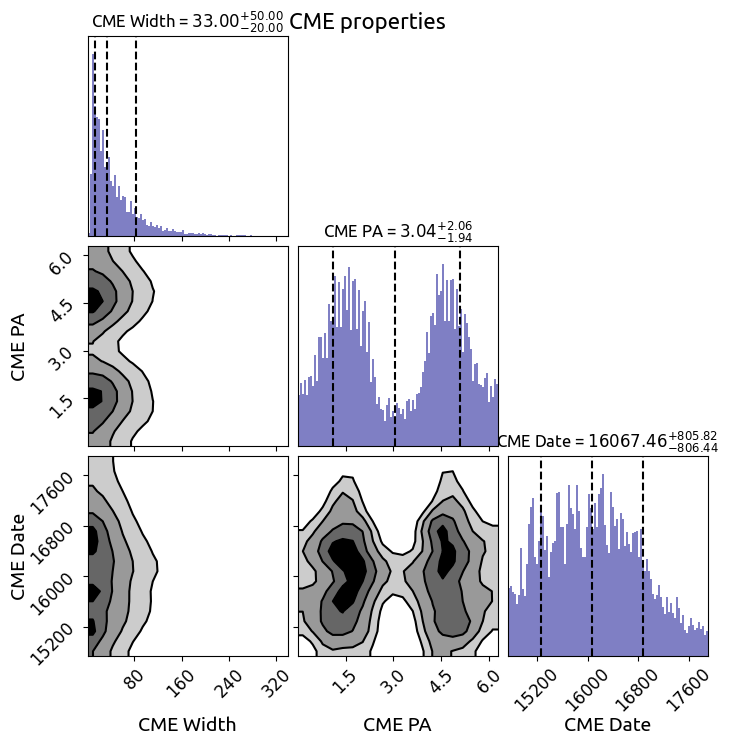

In [21]:
import corner
# Let's see a corner plot first for the real CMEs

data = np.vstack([widths, np.deg2rad(pas), dates])

# Generate the corner plot with improvements
figure = corner.corner(data.T, labels=['CME Width', 'CME PA', 'CME Date'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12, "fontname": "Ubuntu"},
                       label_kwargs={"fontsize": 14, "fontname": "Ubuntu"},
                       hist_kwargs={"histtype": 'stepfilled', "linewidth": 1.5, "alpha": 0.5, "color": 'darkblue'},
                       hist_bin_factor=5,
                       plot_datapoints=False, plot_density=True, fill_contours=True,
                       figsize=(10, 10),  # Adjust the figure size as needed
                       use_math_text=True,  # For LaTeX formatted labels
                       smooth=1.0,
                       )

figure.suptitle('CME properties', fontsize=16, fontname="Ubuntu")
# Adjust overall plot properties
plt.rc('font', size=12)  # Adjust to desired fontsize
plt.rc('axes', titlesize=14)  # Adjust title size
plt.rc('axes', labelsize=14)  # Adjust axis label size
plt.rc('xtick', labelsize=12)  # Adjust x tick label size
plt.rc('ytick', labelsize=12)  # Adjust y tick label size

plt.show()


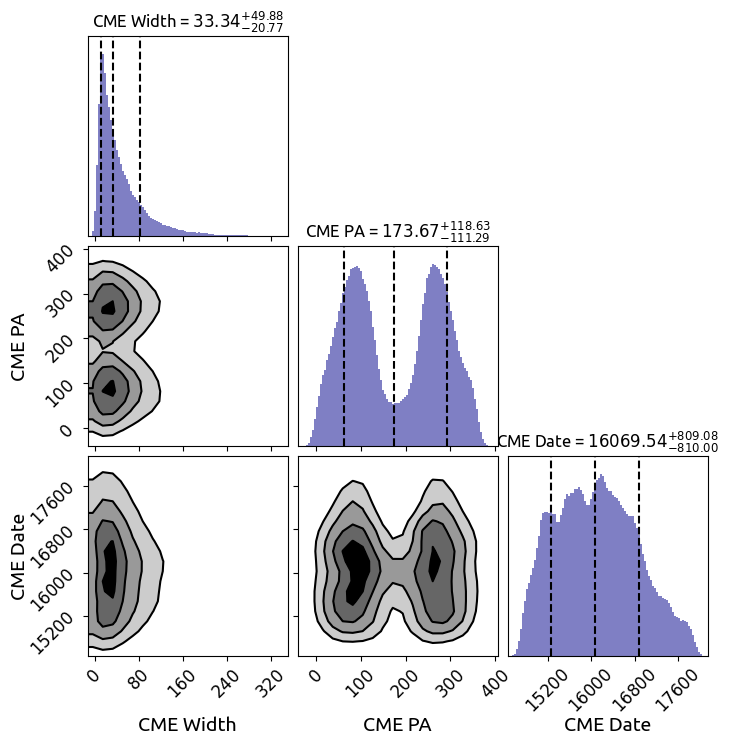

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy.stats import gaussian_kde

kde_data = np.vstack([widths, pas, dates])

kde = gaussian_kde(kde_data, bw_method=0.1)

# Sample from the KDE
samples = kde.resample(1000000)

# Generate the corner plot with improvements
figure = corner.corner(samples.T, labels=['CME Width', 'CME PA', 'CME Date'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12, "fontname": "Ubuntu"},
                       label_kwargs={"fontsize": 14, "fontname": "Ubuntu"},
                       hist_kwargs={"histtype": 'stepfilled', "linewidth": 1.5, "alpha": 0.5, "color": 'darkblue'},
                       hist_bin_factor=5,
                       plot_datapoints=False, plot_density=True, fill_contours=True,
                       figsize=(10, 10),  # Adjust the figure size as needed
                       use_math_text=True,  # For LaTeX formatted labels
                       smooth=1.0,
                       )

# Adjust overall plot properties
plt.rc('font', size=12)  # Adjust to desired fontsize
plt.rc('axes', titlesize=14)  # Adjust title size
plt.rc('axes', labelsize=14)  # Adjust axis label size
plt.rc('xtick', labelsize=12)  # Adjust x tick label size
plt.rc('ytick', labelsize=12)  # Adjust y tick label size

plt.show()


In [37]:
import bisect
# Get all CME numerical dates
MAX_CLOSE = 2

all_dates = sorted(cmes["cme_date_numeric"].to_numpy())

dates_dict = {
    date - MAX_CLOSE / 24: date + MAX_CLOSE / 24 for date in all_dates
}

start_dates = np.array(list(dates_dict.keys()))

# Now, we need a function that does the following:
# Takes in a date, uses bisect to find where it goes in the start_dates array.
# Then, check for the value of start dates just before, if the corresponding value in dates_dict
# is larger than the given date. If so, return False, else true.

def find_shifted_date_if_in_cme(input_date, sorted_cme_start_dates, cme_intervals_dict, max_n_iter=10):
    """
    Attempts to shift the CME candidate date to a valid time slot outside of CME intervals, if necessary.
    
    Args:
    - cme_candidate_date (float): The date to check and possibly shift.
    - sorted_cme_start_dates (np.array): Sorted array of CME start dates.
    - cme_intervals_dict (dict): Dictionary mapping start dates to their corresponding end dates of CMEs.
    
    Returns:
    - tuple: (bool indicating if shift was needed, original or shifted date)
             True if the date is already outside CME intervals, False if a shift was needed.
    """
    cme_candidate_date = input_date

    position = bisect.bisect(sorted_cme_start_dates, cme_candidate_date) - 1
    
    # If the date is before the first CME, it's outside CME times
    if position < 0:
        return (True, cme_candidate_date)
    
    end_date_of_current_interval = cme_intervals_dict[sorted_cme_start_dates[position]]
    
    # Check if the candidate date is within a CME interval
    if end_date_of_current_interval > cme_candidate_date:
        # If within a CME interval, check for a possible shift
        if position + 1 < len(sorted_cme_start_dates):
            start_date_of_next_interval = sorted_cme_start_dates[position + 1]
            # If the current and next intervals don't overlap, we can shift the date
            if end_date_of_current_interval < start_date_of_next_interval:
                # Choose a new date randomly between the current interval's end and the next interval's start
                new_date = np.random.uniform(end_date_of_current_interval, start_date_of_next_interval)
                last_result = (False, new_date)
            else:
                # If overlapping with the next interval or no next interval to check, no shift is possible
                last_result =  (True, cme_candidate_date)
        else:
            # If there's no next interval to check, no shift is possible
            last_result =  (True, cme_candidate_date)
    else:
        # The candidate date is already outside a CME interval
        last_result = (False, cme_candidate_date)

    return last_result


In [36]:
fake_dates = {
    1: 4,
    2.5: 6.5,
    5: 9,
    6: 10,
    8: 12,
    16: 20
}

dates = fake_dates.keys()

sorted_dates = sorted(dates)

test_date = 10

find_shifted_date_if_in_cme(test_date, sorted_dates, fake_dates)

(False, 13.356143825987285)

In [201]:
# Print first 10 pairs in dates_dict

list(dates_dict.items())[:10]

[(14729.95005787037, 14730.116724537038),
 (14730.150081018517, 14730.316747685185),
 (14730.216724537036, 14730.383391203704),
 (14730.46673611111, 14730.633402777778),
 (14730.76673611111, 14730.933402777779),
 (14731.35474537037, 14731.521412037038),
 (14731.645891203703, 14731.812557870371),
 (14731.729224537037, 14731.895891203705),
 (14732.480335648148, 14732.647002314816),
 (14732.629224537037, 14732.795891203705)]

In [202]:
sample_date = 14731.74

find_shifted_date_if_in_cme(sample_date, start_dates, dates_dict)

(False, 14732.287738039158)

In [72]:
# Ratio of cme_halo to non-cme_halo
halo_ratio = cmes["cme_halo"].value_counts(normalize=True)[1]
print(halo_ratio)

# Mean width of CME?
mean_width = cmes["cme_width"].mean()

# What's the solid angle of a cone with the mean cme width?
sa = 2 * np.pi * (1 - np.cos((mean_width / 2) * np.pi / 180))
print(sa / (4 * np.pi))

0.022058316674708763
0.05571605164772753


In [79]:
from tqdm import tqdm
# Ok, conditional sampling cannot be done with scipy. Anyways.

# So we'll bin the data, generate a KDE for width and PA for each bin and sample from there.

# Let's define the bin size
bin_size = 3 * 31 # Months to days

# Now, we need to bin the data

# Get the min and max dates
dates = cmes["cme_date_numeric"].to_numpy()

min_date = dates.min()
max_date = dates.max()

# Bin it
bins = np.arange(min_date, max_date + bin_size, bin_size)

TOTAL = 110000
N_PER_BIN = TOTAL // len(bins)

# Print min bin, min date and max bin, max date
print(mdates.num2date(bins[0]), mdates.num2date(min_date), mdates.num2date(bins[-1]), mdates.num2date(max_date))

# Now, we need to generate a KDE for each bin
results = []

# Start a tqdm
q = tqdm(total=len(bins) * N_PER_BIN)

for i in range(len(bins) - 1):
    # Get the CMEs in the bin
    cmes_in_bin = cmes[(cmes["cme_date_numeric"] >= bins[i]) & (cmes["cme_date_numeric"] < bins[i + 1])]
    cmes_in_bin = cmes_in_bin[["cme_width", "cme_pa"]].dropna().to_numpy().T

    current_results = []

    # Generate the KDE
    kde = gaussian_kde(cmes_in_bin, bw_method=0.01)

    while len(current_results) < N_PER_BIN:
        sample = kde.resample(1).T[0]

        # Values must be between 0 and 360
        if not (0 <= sample[0] <= 360 and 0 <= sample[1] <= 360):
            continue

        is_within_cme = True

        while is_within_cme:
            # Check whether it's inside a CME_interval

            # Random date within the bin
            sample_date = np.random.uniform(bins[i], bins[i + 1])

            is_within_cme, updated_date = find_shifted_date_if_in_cme(sample_date, start_dates, dates_dict)

        sample = np.append(sample, updated_date)

        # Change sample to be a HALO CME with probability equal to the ratio of halo CMEs

        if np.random.rand() < halo_ratio:
            sample[0] = 360
            sample[1] = np.nan

        current_results.append(sample)
        q.update(1)

    results.extend(current_results)

q.close()

results = np.array(results).T
print(results.shape)

2010-05-01 00:48:05+00:00 2010-05-01 00:48:05+00:00 2019-03-30 00:48:05+00:00 2019-01-07 02:00:05+00:00


 97%|█████████▋| 106925/109980 [00:07<00:00, 13920.94it/s]


(3, 106925)


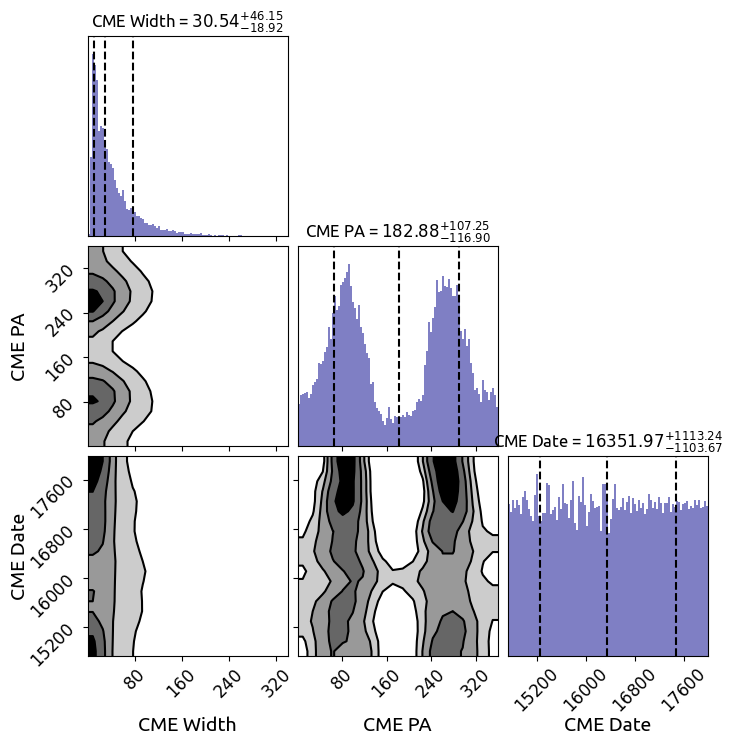

In [80]:

# Generate the corner plot with improvements
sanitized_results = results.copy()
# Drop the nan pa entries
sanitized_results = sanitized_results.T[~np.isnan(sanitized_results[1])]
sanitized_results = sanitized_results.T

figure = corner.corner(sanitized_results.T, labels=['CME Width', 'CME PA', 'CME Date'],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12, "fontname": "Ubuntu"},
                       label_kwargs={"fontsize": 14, "fontname": "Ubuntu"},
                       hist_kwargs={"histtype": 'stepfilled', "linewidth": 1.5, "alpha": 0.5, "color": 'darkblue'},
                       hist_bin_factor=5,
                       plot_datapoints=False, plot_density=True, fill_contours=True,
                       figsize=(10, 10),  # Adjust the figure size as needed
                       use_math_text=True,  # For LaTeX formatted labels
                       smooth=1.0,
                       )

# Adjust overall plot properties
plt.rc('font', size=12)  # Adjust to desired fontsize
plt.rc('axes', titlesize=14)  # Adjust title size
plt.rc('axes', labelsize=14)  # Adjust axis label size
plt.rc('xtick', labelsize=12)  # Adjust x tick label size
plt.rc('ytick', labelsize=12)  # Adjust y tick label size

plt.show()


In [83]:

# Double check that no date is within a CME interval
drop_indices = []

for i, date in enumerate(results[2]):
    is_within_cme, updated_date = find_shifted_date_if_in_cme(date, start_dates, dates_dict)
    if is_within_cme:
        # Just drop it, let's make a list of indices that are meh
        drop_indices.append(i)

results_mask = np.ones(results.shape[1], dtype=bool)

results_mask[drop_indices] = False

results = results.T[results_mask].T

for i, date in enumerate(results[2]):
    is_within_cme, updated_date = find_shifted_date_if_in_cme(date, start_dates, dates_dict)
    if is_within_cme:
        print("STILL WITHIN CME")

In [84]:
cmes.columns

Index(['cme_id', 'cme_date', 'cme_pa', 'cme_width', 'cme_halo', 'cme_seen_in',
       'cme_three_points', 'cme_quality', 'image_timestamp',
       'cme_date_numeric'],
      dtype='object')

In [85]:
cmes.iloc[0]

cme_id                20100501004805101
cme_date            2010-05-01 00:48:05
cme_pa                            101.0
cme_width                         126.0
cme_halo                              0
cme_seen_in                           0
cme_three_points                      0
cme_quality                           0
image_timestamp     2010-05-01 00:48:00
cme_date_numeric           14730.033391
Name: 0, dtype: object

In [103]:
# Now, for each entry I need to generate a cme_id, format the date, get the cme_halo, set cme_seen_in, cme_three_points and cme_quality to 0 and put all into a dataframe

# Generate cme_id
# The cme id is YYYYMMDDHHMMSSCME_WIDTH(3 digits, int and 999 if halo)
# We know if it's halo because the pa is nan

cme_ids = []

for entry in results.T:
    width, pa, date = entry

    date_id = mdates.num2date(date).strftime("%Y%m%d%H%M%S")

    width_id = str(int(width)).zfill(3) if not np.isnan(pa) else "999"

    cme_ids.append(date_id + width_id)


# Now, we need to format the date
    
dates = [mdates.num2date(date).strftime("%Y-%m-%d %H:%M:%S") for date in results[2]]

# Now, we need to get the cme_halo

cmes_halo = [0 if not np.isnan(pa) else 1 for pa in results[1]]

cmes_widths = results[0].astype(int)
cmes_pas = [int(pa) if not np.isnan(pa) else np.nan for pa in results[1]]

# Now, we need to get the cme_seen_in, cme_three_points and cme_quality

cmes_seen_in = [0 for _ in results[0]]
cmes_three_points = [0 for _ in results[0]]
cmes_quality = [0 for _ in results[0]]

# Now, we need to put it all into a dataframe

synthetic_cmes = pd.DataFrame({
    "cme_id": cme_ids,
    "cme_date": dates,
    "cme_pa": cmes_pas,
    "cme_width": cmes_widths,
    "cme_halo": cmes_halo,
    "cme_seen_in": cmes_seen_in,
    "cme_three_points": cmes_three_points,
    "cme_quality": cmes_quality
})

In [104]:
synthetic_cmes[synthetic_cmes["cme_halo"] == 1]

,cme_id,cme_date,cme_pa,cme_width,cme_halo,cme_seen_in,cme_three_points,cme_quality
9,20100704053815999,2010-07-04 05:38:15,NaN,360,1,0,0,0
18,20100801062734999,2010-08-01 06:27:34,NaN,360,1,0,0,0
28,20100529044034999,2010-05-29 04:40:34,NaN,360,1,0,0,0
93,20100721171603999,2010-07-21 17:16:03,NaN,360,1,0,0,0
140,20100701151832999,2010-07-01 15:18:32,NaN,360,1,0,0,0
...,...,...,...,...,...,...,...,...
106758,20190105140349999,2019-01-05 14:03:49,NaN,360,1,0,0,0
106761,20190222004855999,2019-02-22 00:48:55,NaN,360,1,0,0,0
106768,20190124025908999,2019-01-24 02:59:08,NaN,360,1,0,0,0
106834,20190107163225999,2019-01-07 16:32:25,NaN,360,1,0,0,0


In [105]:
# Save to csv

synthetic_cmes.to_csv("../data/processed/synthetic_cmes.csv", index=False)